In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False
%cd ..

/jupyter-lab/repo/bigstar


# Import Modules

In [533]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["TRANSFORMERS_VERBOSITY"] = "error"

import pickle
from collections import Counter
from functools import partial
from pathlib import Path
from typing import Dict, Iterable, Tuple

import joblib
import matplotlib.pyplot as plt
import mecab_ko as mecab
import nlpaug.augmenter.word as naw
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from nlpaug.util import Action
from scipy.sparse import csr_matrix
from scipy.special import softmax
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_recall_fscore_support,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from src.base_trainer import get_ckpt_path, get_model_hparams, load_model_state
from src.baseline.models import BaselineModel, BaselineModelWithMLAttention
from src.baseline.trainer import BaselineTrainerModel
from src.datasets import LotteQADataset, collate_fn
from src.eda import EDA
from src.utils import (
    delete_list_elements,
    filter_arguments,
    get_label_encoder,
    get_n_samples,
)
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from transformers import (
    AutoConfig,
    AutoModel,
    AutoModelForMaskedLM,
    AutoTokenizer,
    MarianMTModel,
)
from transformers.models.marian.convert_marian_to_pytorch import (
    load_config_from_state_dict,
)
from transformers.tokenization_utils_base import PreTrainedTokenizerBase

# EDA

## # of Samples

In [30]:
train_df1 = pd.read_csv("data/train01.csv")
train_df1 = train_df1[train_df1["QA여부"] == "q"]

train_df2 = pd.read_csv("data/train02.csv")
train_df2 = train_df2[train_df2["QA여부"] == "q"]

train_df = pd.concat([train_df1, train_df2])

valid_df = pd.read_csv("data/validation.csv")
valid_df = valid_df[valid_df["QA여부"] == "q"]

test_df = pd.read_csv("data/test.csv")
test_df = test_df[test_df["QA여부"] == "q"]

print(f"# of rows (train01): {len(train_df1):,}")
print(f"# of rows (train02): {len(train_df2):,}")
print(f"# of rows (validation): {len(valid_df):,}")
print(f"# of rows (test): {len(test_df):,}")

train_df1.head()

# of rows (train01): 441,874
# of rows (train02): 273,175
# of rows (validation): 114,288
# of rows (test): 89,878


,IDX,발화자,발화문,카테고리,QA번호,QA여부,감성,인텐트,가격,수량,크기,장소,조직,사람,시간,날짜,상품명,상담번호,상담내순번
0,433813,c,높이 길이를 좀 더 길게 해주실 수 있나요?,가구인테리어,1,q,m,제품_정보,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1
2,441787,c,그레이 커튼을 배송받았는데요레이스 커튼이 흰색이 아니고 회색이네요 잘못 온 건가요?,가구인테리어,2,q,m,배송_오류,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,그레이 커튼|레이스 커튼,2,1
4,325930,c,거실 총길이가 가로 480세로 230인데 어떤 걸로 신청해야 하나요?,가구인테리어,4,q,m,제품_정보,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,1
6,70824,c,레이스 커튼만 개별 구매 안 될까요?,가구인테리어,5,q,m,구매_제품,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,레이스 커튼,5,1
8,253329,c,화이트 구입 시 봉색이 화이트로 오나요?,가구인테리어,6,q,m,제품_구성,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,1


## # of Samples per Label

In [83]:
value_counts = pd.DataFrame(train_df['인텐트'].value_counts())
value_counts

,인텐트
배송_날짜,153516
제품_정보,124759
제품_구성,46528
제품_방법,42915
제품_추천,39719
...,...
주문_변경,132
포장_비용,125
주문_오류,106
주문_추가,103


## Label Distribution

<AxesSubplot:>

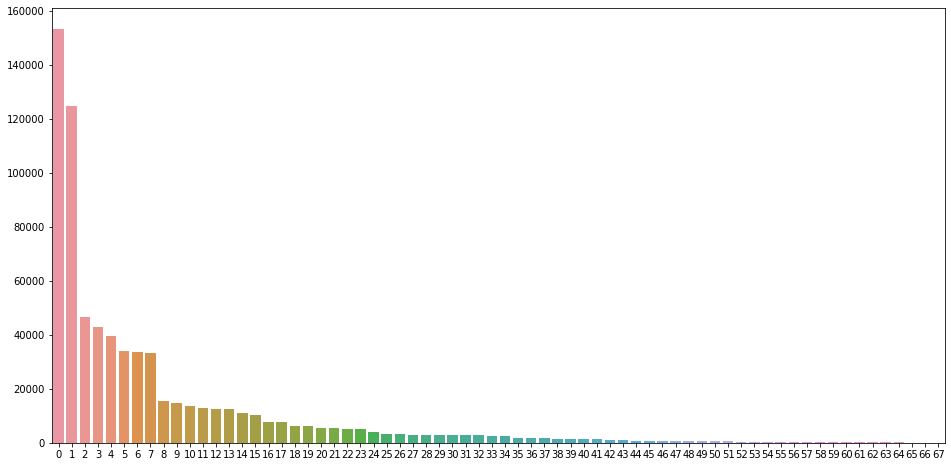

In [82]:
plt.figure(figsize=(16, 8))
sns.barplot(x=np.arange(len(value_counts)), y=value_counts["인텐트"].to_numpy())

## Stat of Input Token

In [124]:
tokenzier = AutoTokenizer.from_pretrained("monologg/koelectra-small-v3-discriminator")
input_lengths = []
for text in tqdm(train_df["발화문"]):
    input_lengths.append(len(tokenzier(text)["input_ids"]))

input_lengths = np.array(input_lengths)
print(f"avg. length of input token: {np.mean(input_lengths):.2f}")
print(f"std. length of input token: {np.std(input_lengths):.2f}")
print(f"median length of input token: {np.median(input_lengths)}")
print(f"min length of input token: {np.min(input_lengths):.2f}")
print(f"max length of input token: {np.max(input_lengths):.2f}")

avg. length of input token: 18.30
std. length of input token: 9.30
median length of input token: 16.0
min length of input token: 4.00
max length of input token: 233.00


# Dataset

In [161]:
dataset = LotteQADataset()
le = LabelEncoder().fit(dataset.y)
tokenizer = AutoTokenizer.from_pretrained("monologg/koelectra-small-v3-discriminator")

In [162]:
dataloader = DataLoader(
    dataset,
    batch_size=16,
    collate_fn=partial(collate_fn, tokenizer=tokenizer, le=le, max_length=30),
)

In [163]:
batch = next(iter(dataloader))

# Model

In [198]:
model = BaselineModel(
    num_labels=len(le.classes_),
    pretrained_model_name="monologg/koelectra-base-v3-discriminator",
    use_layernorm=True,
)

Some weights of the model checkpoint at monologg/koelectra-base-v3-discriminator were not used when initializing ElectraModel: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Test

In [736]:
run_id = "d2f3d232290d410bb73401df40041d07"
ckpt_path = get_ckpt_path(log_dir="./logs", run_id=run_id, load_best=True)
model_hparams = get_model_hparams("./logs", run_id, BaselineTrainerModel.MODEL_HPARAMS)
le = get_label_encoder("./cache/label_encoder.joblib")

model_cls = (
    BaselineModel
    if model_hparams["model_name"] == "Baseline"
    else BaselineModelWithMLAttention
)

model = model_cls(
    num_labels=len(le.classes_), **filter_arguments(model_hparams, model_cls)
)

load_model_state(model, ckpt_path, substitution=(r"^model\.", ""))

test_dataset = LotteQADataset(mode="test")
tokenizer = AutoTokenizer.from_pretrained(model_hparams["pretrained_model_name"])
test_dataloader = DataLoader(
    test_dataset,
    batch_size=16,
    pin_memory=True,
    num_workers=4,
    collate_fn=partial(
        collate_fn, tokenizer=tokenizer, le=le, max_length=model_hparams["max_length"]
    ),
)

device = torch.device("cuda")

model.to(device)
model.eval()
probs = []

for batch_x, batch_y in tqdm(test_dataloader):
    batch_x = {k: v.to(device) for k, v in batch_x.items()}
    with torch.no_grad(), torch.cuda.amp.autocast():
        outputs = model(batch_x)
    probs.append(outputs.cpu())

probs = np.concatenate(probs)
predictions = probs.argmax(axis=-1)

gt = le.transform(test_dataset.y)
f1_micro = f1_score(gt, predictions, average="micro")
prec_macro, recall_macro, f1_macro, support = precision_recall_fscore_support(
    gt,
    predictions,
    average="macro",
    zero_division=0,
)
prec_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
    gt,
    predictions,
    average="weighted",
    zero_division=0,
)
prec, recall, f1, _ = precision_recall_fscore_support(
    gt, predictions, average=None, zero_division=0
)

print(f"f1        (micro): {f1_micro:.4f}")
print(f"prec      (macro): {prec_macro:.4f}")
print(f"recall    (macro): {recall_macro:.4f}")
print(f"f1        (macro): {f1_macro:.4f}")
print(f"prec   (weighted): {prec_weighted:.4f}")
print(f"recall (weighted): {recall_weighted:.4f}")
print(f"f1     (weighted): {f1_weighted:.4f}")

matrix = confusion_matrix(gt, predictions)

data = {
    "intent": le.classes_,
    "support": matrix.sum(axis=-1),
    "# to tp": np.diag(matrix),
    "# of predicted": matrix.sum(axis=0),
}

df = pd.DataFrame(data)
df.to_excel("outputs/predictions.xlsx", index=False)

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/5618 [00:01<?, ?it/s]

f1        (micro): 0.9360
prec      (macro): 0.6901
recall    (macro): 0.6018
f1        (macro): 0.6283
prec   (weighted): 0.9321
recall (weighted): 0.9360
f1     (weighted): 0.9331


## Analysis Predictions

In [180]:
label_idx = le.transform(["제품_일반"])[0]
predicted_label_idx = np.where(matrix[:, label_idx] != 0)[0]
predicted_label_idx = predicted_label_idx[np.where(predicted_label_idx != label_idx)[0]]
predicted = matrix[:, label_idx][predicted_label_idx]

df = pd.DataFrame(
    {"intent": le.classes_[predicted_label_idx], "# of predicted": predicted}
)
df.sort_values(by="# of predicted", ascending=False)

,intent,# of predicted
20,제품_정보,95
19,제품_재고,54
14,제품_방법,41
13,제품_구성,32
1,결제_일반,24
11,웹사이트_사용,14
9,배송_일반,9
22,제품_커스텀,7
18,제품_입고,7
21,제품_추천,5


# Easy Data Augmentation

In [209]:
train_dataset = LotteQADataset()

In [249]:
eda = EDA(num_aug=3, p_sr=0.5, p_ri=0.5, p_rd=0, p_rs=0)

In [350]:
ridx = np.random.randint(len(train_dataset))
original = train_dataset[ridx][0]
augmented = eda(original)

print(f"Original text ({ridx}):")
print(original)
print()
print("Augmented text:")
print("\n".join(augmented))

Original text (580718):
저번에도 신청해서 이번에도 신청했는데 아직도 배송 준비 중이네 여 언제쯤 받아볼 수 있나여? 빨리 보내주세여

Augmented text:
저번에도 신청해서 이번에도 신청했는데 아직도 배송 준비 중이네 여 언제쯤 받아볼 수 있나여? 빨리 보내주세여


In [194]:
eda = EDA(num_aug=3, p_sr=0, p_ri=0, p_rd=0.5, p_rs=0.5)
train_dataset = LotteQADataset()
augmented = []
for text, label in tqdm(train_dataset):
    aug = eda(text)
    augmented.extend([(t, label) for t in aug])

  0%|          | 0/715049 [00:00<?, ?it/s]

In [195]:
text, labels = zip(*augmented)
df = pd.DataFrame({"발화문": text, "인텐트": labels})
df.to_csv('data/augmented.eda.v2.csv', index=False)

In [394]:
model.eval()
predictions = []

for batch_x, batch_y in tqdm(test_dataloader):
    batch_x = {k: v.to(device) for k, v in batch_x.items()}
    with torch.no_grad():
        outputs = model(batch_x)
    predictions.append(outputs.argmax(dim=-1).cpu())

predictions = np.concatenate(predictions)

le = get_label_encoder('./cache/label_encoder')
gt = le.transform(test_dataset.y)
f1_micro = f1_score(gt, predictions, average='micro')
f1_macro = f1_score(gt, predictions, average='macro')
f1 = f1_score(gt, predictions, average=None)

print(f"f1 (micro): {f1_micro:.4f}")
print(f"f1 (macro): {f1_macro:.4f}")

  0%|          | 0/28087 [00:01<?, ?it/s]

f1 (micro): 0.7305
f1 (macro): 0.5125


In [396]:
counter = Counter(gt)

label, cnt = zip(*counter.items())
label = np.array(label)
cnt = np.array(cnt)
idx = np.argsort(label)

data = {"intent": le.classes_, "f1": f1, "support": cnt[idx]}
df = pd.DataFrame(data)
df.to_excel("predictions.xlsx", index=False)

# Backtranslation

In [4]:
device = torch.device("cuda")

def collate_fn_seq2seq(
    batch: Iterable[Tuple[str, str]],
    tokenizer: PreTrainedTokenizerBase,
) -> Tuple[Dict[str, torch.Tensor]]:
    x = [b[0] for b in batch]
    inputs = tokenizer(x, padding=True, return_tensors="pt")
    return inputs

In [3]:
src_model_name = "Helsinki-NLP/opus-mt-ko-en"
src_tokenizer = AutoTokenizer.from_pretrained(src_model_name)
src_model = MarianMTModel.from_pretrained(src_model_name)
_ = src_model.to(device)

In [ ]:
tgt_model_name = "Helsinki-NLP/opus-mt-tc-big-en-ko"
tgt_tokenizer = AutoTokenizer.from_pretrained("../Opus-MT/models/en-ko-2")
tgt_model = MarianMTModel.from_pretrained(tgt_model_name)
_ = tgt_model.to(device)

In [313]:
train_dataset = LotteQADataset()
train_dataloader = DataLoader(
    train_dataset,
    batch_size=32,
    collate_fn=partial(collate_fn_seq2seq, tokenizer=src_tokenizer),
    pin_memory=True,
    num_workers=6,
)

In [ ]:
src_translated = []

src_model.eval()

for batch_x in tqdm(train_dataloader):
    batch_x = {k: v.to(device) for k, v in batch_x.items()}
    with torch.no_grad():
        encoded = src_model.generate(**batch_x)
    with src_tokenizer.as_target_tokenizer():
        src_translated.append(
            src_tokenizer.batch_decode(encoded.cpu(), skip_special_tokens=True)
        )

In [101]:
texts = train_dataset.x[:20].tolist()
texts

['높이 길이를 좀 더 길게 해주실 수 있나요?',
 '그레이 커튼을 배송받았는데요레이스 커튼이 흰색이 아니고 회색이네요 잘못 온 건가요?',
 '거실 총길이가 가로 480세로 230인데 어떤 걸로 신청해야 하나요?',
 '레이스 커튼만 개별 구매 안 될까요?',
 '화이트 구입 시 봉색이 화이트로 오나요?',
 '화이트 구매 안 되나요?',
 '주문 가능할까요?',
 '똑같은 회사에 똑같은 상품인데 2만원 더 비싼데 혹시 상품 이 틀리나요?',
 '사이즈를 몇으로 사야 하나요?',
 '검수 잘해서 배송 부탁드립니다 그리고 배송 날짜가 좀 늦게 뜨는 데 이번 주에 받을 수 있을까요?',
 '대형 사려고 하는데 커튼봉을 시중에 파는 3.5미리로 바꾸어도 커튼 구멍에 맞을까요?',
 '화이트는 언제 입고되나요?',
 '냄새가 많이 나는데 세탁을 하고 사용해야 하나요?',
 '핀 형도 가능한가요?',
 '겨울 방풍 효과도 있나요?',
 '길이 250으로는 안 되나요?',
 '로제2와 로즈마리의 차이점은 뭔가요?',
 '가로490문의요 중형 2개를 사면 커텐봉을 하나로 연결할 수 있나요?',
 '베이지 주문했는데 타이백은 어떤 색 그리고 어떤 게오나요?',
 '가로길이가 340인데 사이즈뭘로 해야 되나요?']

In [103]:
encoded = src_tokenizer(texts, padding=True, return_tensors='pt')
translated = src_model.generate(**encoded)
src_text = src_tokenizer.batch_decode(translated, skip_special_tokens=True)
src_text

['Can you give me a little longer?',
 "The lace curtains are not white, they're gray.",
 'The total length of the living room is 480 years and 230, what should I apply for?',
 "Can't we just buy a lace curtain?",
 'When you buy white, does the bag come to white?',
 "Can't we buy a white one?",
 'Can you order it?',
 "It's the same company and it's worth 20 bucks more, but is it wrong?",
 'What size do I have to buy?',
 "I'd like you to take care of it, and do you mind if I take it this week when the delivery date's up a little late?",
 "I'm trying to buy a big one, but will I fit the curtain hole in a three-and-a-half-a-half-year-old market with a curtain bar?",
 'When are you wearing white?',
 'You smell a lot, so should I wash it and use it?',
 'Is Finn available, too?',
 'Is there a winter wind effect?',
 'Is it 250 feet long?',
 "What's the difference between Roger II and Rosemary?",
 '490 across. If you buy two mediums, can you connect them together?',
 "I ordered a bag of beige. 

In [297]:
encoded = target_tokenizer(src_text, padding=True, return_tensors="pt")
translated = target_model.generate(**encoded)
with target_tokenizer.as_target_tokenizer():
    tgt_text = target_tokenizer.batch_decode(translated, skip_special_tokens=True)
tgt_text

['조금만 더 기다려 주시겠어요?',
 '레이스 커튼은 흰색이 아니라 회색입니다.',
 '거실의 총 길이는 480 년과 230 년이며, 무엇을 신청해야합니까?',
 '그냥 커튼 하나 사면 안 돼?',
 '흰색을 구입하면 가방이 흰색으로 나오나요?',
 '흰색 하나 사면 안 돼?',
 '당신은 그것을 주문할 수 있습니까?',
 '같은 회사이고 20 달러 더 가치가 있지만 잘못 되었습니까?',
 '어떤 사이즈를 구매해야 하나요?',
 '난 당신이 그것을 처리 하 고 싶습니다., 배달 날짜가 조금 늦게 이번 주에 그것을 받아도 될까요?',
 '나는 큰 것을 사려고 노력하고있다. 그러나 나는 커튼 막대가있는 3 년 반의 시장에 커튼 구멍을 넣을 것인가?',
 '흰색은 언제 입고되나요?',
 '냄새를 많이 맡으셨는데, 씻어서 사용해도 되나요?',
 '핀도 사용할 수 있습니까?',
 '겨울 바람의 영향이 있습니까?',
 '길이가 250 피트입니까?',
 'Roger II와 Rosemary의 차이점은 무엇입니까?',
 '490 가로로. 두 개의 매체를 구입하면 함께 연결할 수 있습니까?',
 '베이지색 가방을 주문했는데 무슨 색이고 무슨 일이에요?',
 '폭이 340개인데 크기가 어떻게 되나요?']

---

In [31]:
src_translated = joblib.load("./outputs/backtranslation/src_translated.joblib")
tgt_translated = joblib.load("./outputs/backtranslation/tgt_translated.joblib")

In [23]:
train_dataset = LotteQADataset()

In [60]:
df = pd.DataFrame(
    data={
        "ko": train_dataset.x,
        "en": src_translated,
        "ko (back)": tgt_translated,
        "intent": train_dataset.y,
    }
)

df

,ko,en,ko (back),intent
0,높이 길이를 좀 더 길게 해주실 수 있나요?,Can you give me a little longer?,조금만 더 기다려 주시겠어요?,제품_정보
1,그레이 커튼을 배송받았는데요레이스 커튼이 흰색이 아니고 회색이네요 잘못 온 건가요?,"The lace curtains are not white, they're gray.",레이스 커튼은 흰색이 아니라 회색입니다.,배송_오류
2,거실 총길이가 가로 480세로 230인데 어떤 걸로 신청해야 하나요?,The total length of the living room is 480 yea...,"거실의 총 길이는 480 년과 230 년이며, 무엇을 신청해야합니까?",제품_정보
3,레이스 커튼만 개별 구매 안 될까요?,Can't we just buy a lace curtain?,그냥 커튼 하나 사면 안 돼?,구매_제품
4,화이트 구입 시 봉색이 화이트로 오나요?,"When you buy white, does the bag come to white?",흰색을 구입하면 가방이 흰색으로 나오나요?,제품_구성
...,...,...,...,...
715044,일반 간이영수증에 찍으려고 하는데 사이즈 뭐로 해야 하나요?,"I'm trying to get a normal liver receipt, but ...",나는 정상적인 간 영수증을 얻으려고 노력하고 있지만 그 크기는 얼마입니까?,제품_추천
715045,oo o+전서체로 이쁘게 해서 보내주세요 그리고 언제쯤 받아볼 수 있나요?,"Send it to me with your oo-o+ telegraph, and w...",Oo-o+ 전신으로 나에게 보내면 언제 얻을 수 있습니까?,배송_날짜
715046,입력 내용 다시 입력해야 되나요?,Do I have to re-enter the input?,입력을 다시 입력해야 하나요?,제품_일반
715047,지금 주문하면 언제 보내주세요?,"If you order now, when will you let me go?",지금 주문하면 언제 날 보내줄 거야?,배송_날짜


In [65]:
df[df['en'].isnull()]

,ko,en,ko (back),intent


In [36]:
x = np.concatenate([train_dataset.x, tgt_translated])

In [43]:
y = np.concatenate([train_dataset.y, train_dataset.y])

In [46]:
idx = np.arange(len(x))
np.random.shuffle(idx)

In [47]:
idx

array([ 857385, 1027034,  692522, ...,  585390,  448823,   80854])

In [48]:
x = x[idx]
y = y[idx]

In [85]:
df = pd.DataFrame(data={"발화문": x, "인텐트": y})

In [94]:
df.to_csv("data/augmented.backtranslation.v1.csv", index=False)

# M2m

In [23]:
train_dataset = LotteQADataset()
le = get_label_encoder("cache/label_encoder.joblib")
y = le.transform(train_dataset.y)

In [24]:
counter = Counter(y)
idx, n_samples = zip(*counter.items())
idx = np.array(idx)
n_samples = np.array(n_samples)
n_samples = n_samples[np.argsort(idx)]
n_samples = torch.from_numpy(n_samples)

In [57]:
n_samples

tensor([   500,   1858,   1371,    827,   4003,    313,    155,    454,    202,
           255,   6047,    177,    898,   1804,   1223,   5446,   2915,   4971,
         11123,    141,    556,   3415,   1276,    795,    181,     64,    161,
        153516,   5287,  12500,  13651,  12422,   2845,   2485,    570,   1419,
           633,   2727,    379,   6373,  46528,   2799,  42915,  15572,   7786,
          2531,  10440,   2880,  33130,  34191,  12886, 124759,  39719,   1224,
         14910,  33519,    132,    106,    429,    103,   1664,    125,    849,
          5508,    496,   2860,   7676,   3374])

In [56]:
torch.bernoulli(n_samples[n_samples.argsort(descending=True)] / n_samples.max())

tensor([0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [113]:
y_sample = torch.from_numpy(y[:32])

# Label Distribution

In [3]:
def plot_label_distribution(df, columns=None):
    value_counts = pd.DataFrame(df["인텐트"].value_counts())
    if columns is not None:
        value_counts = value_counts.loc[columns]
    plt.figure(figsize=(16, 8))
    sns.barplot(x=np.arange(len(value_counts)), y=value_counts["인텐트"].to_numpy())

## Original Dataset

<AxesSubplot:>

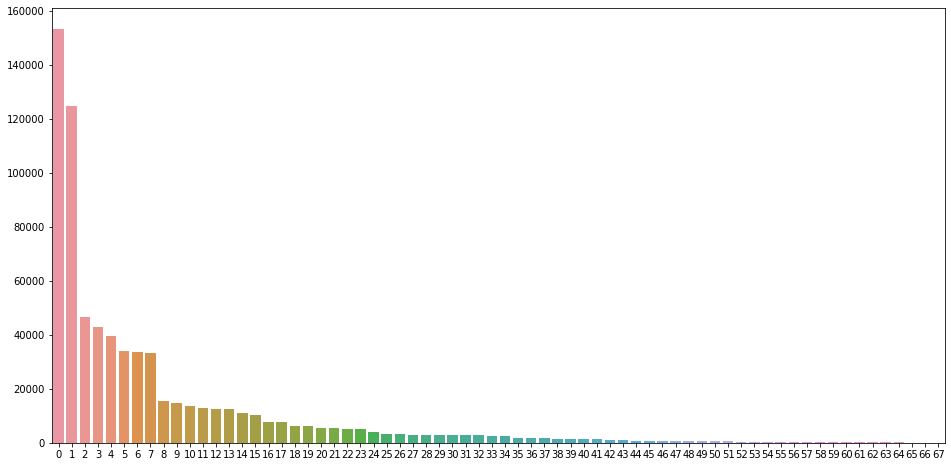

In [419]:
orig_df = pd.concat(
    [
        pd.read_csv("data/train01.csv", low_memory=False),
        pd.read_csv("data/train02.csv", low_memory=False),
    ]
)
orig_df = orig_df[orig_df["QA여부"] == "q"]
orig_df = orig_df[["발화문", "인텐트"]]

orig_value_counts = pd.DataFrame(orig_df["인텐트"].value_counts())

plt.figure(figsize=(16, 8))
sns.barplot(x=np.arange(len(orig_value_counts)), y=orig_value_counts["인텐트"].to_numpy())

## EDA v1

<AxesSubplot:>

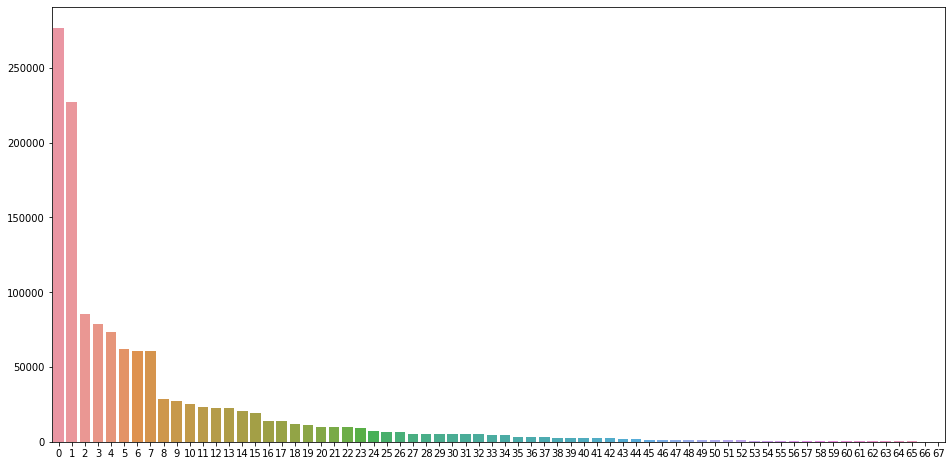

In [307]:
df = pd.read_csv("data/augmented.eda.v1.csv")
value_counts = pd.DataFrame(df["인텐트"].value_counts())
plt.figure(figsize=(16, 8))
sns.barplot(x=np.arange(len(value_counts)), y=value_counts["인텐트"].to_numpy())

## Backtranslation v1

<AxesSubplot:>

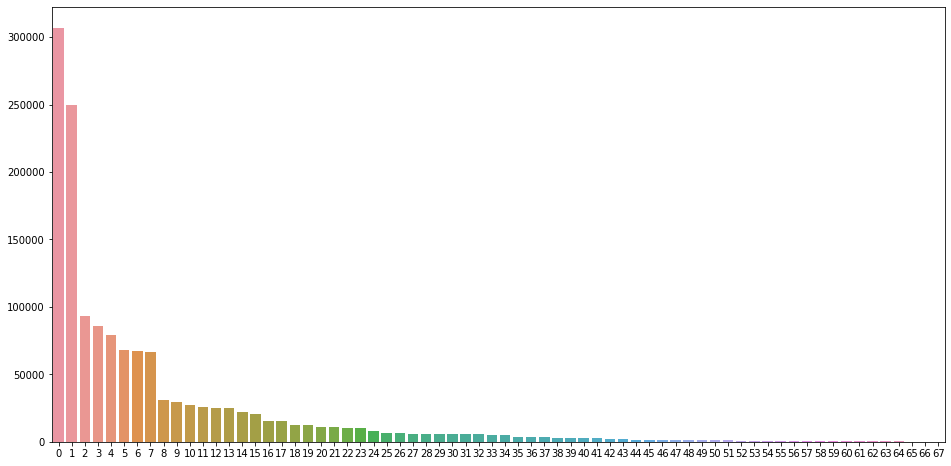

In [305]:
df = pd.read_csv("data/augmented.backtranslation.v1.csv")
value_counts = pd.DataFrame(df["인텐트"].value_counts())
plt.figure(figsize=(16, 8))
sns.barplot(x=np.arange(len(value_counts)), y=value_counts["인텐트"].to_numpy())

## Backtranslation v2

<AxesSubplot:>

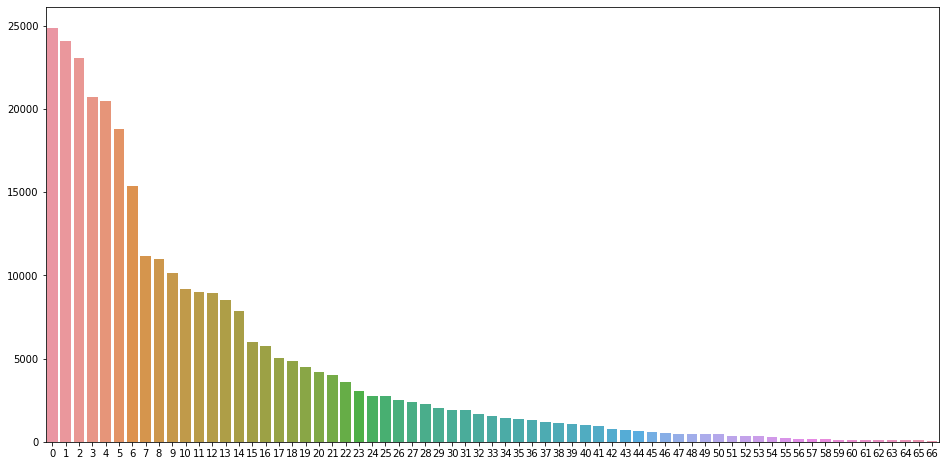

In [440]:
back_translated = joblib.load("outputs/backtranslation/back_translated.joblib")
texts, intents = zip(*back_translated)
df = pd.DataFrame({"발화문": texts, "인텐트": intents})
value_counts = pd.DataFrame(df["인텐트"].value_counts())
plt.figure(figsize=(16, 8))
sns.barplot(x=np.arange(len(value_counts)), y=value_counts["인텐트"].to_numpy())

## Dataset (Only main category)

<AxesSubplot:>

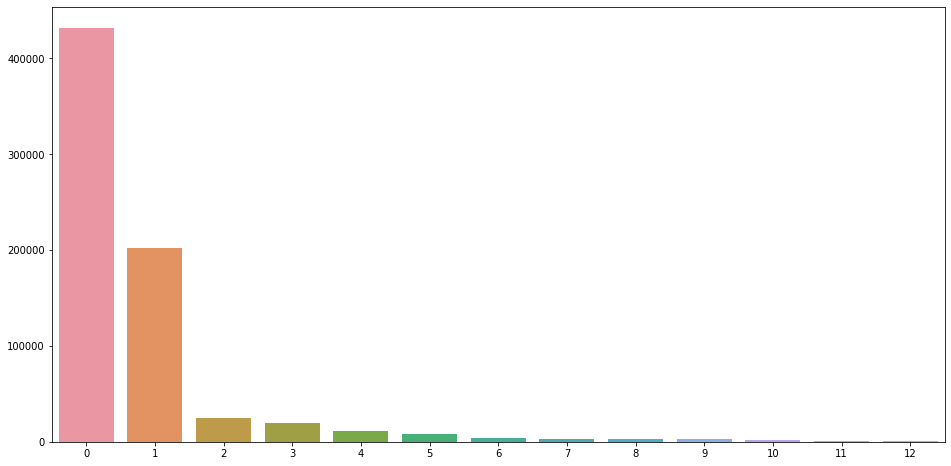

In [432]:
orig_df = pd.read_csv("data/train.csv", low_memory=False)
orig_df = orig_df[orig_df["QA여부"] == "q"]
orig_df = orig_df[["발화문", "인텐트"]]

orig_value_counts = pd.DataFrame(orig_df["인텐트"].value_counts())

plt.figure(figsize=(16, 8))
sns.barplot(x=np.arange(len(orig_value_counts)), y=orig_value_counts["인텐트"].to_numpy())

## Backtranslation

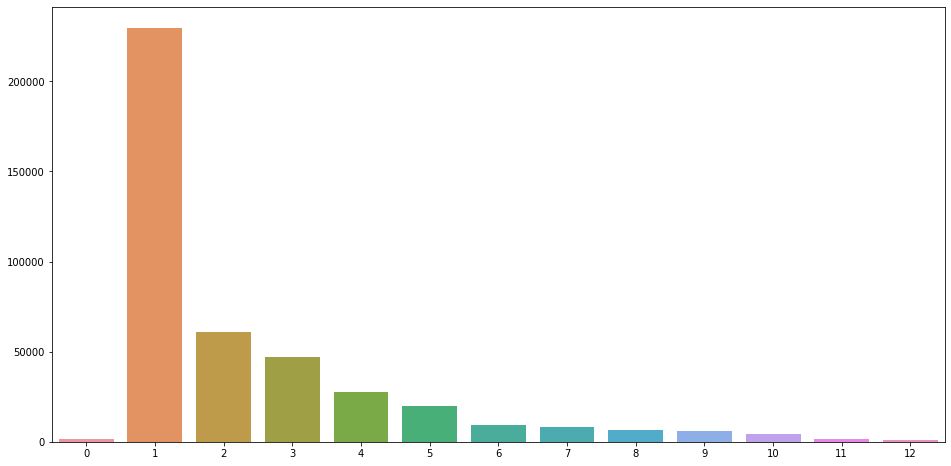

In [581]:
back_translated = joblib.load("outputs/backtranslation/back_translated.v3.joblib")
texts, intents = zip(*back_translated)
back_df = pd.DataFrame({"발화문": texts, "인텐트": intents})
plot_label_distribution(back_df, orig_df["인텐트"].value_counts().index)

## Merge Data

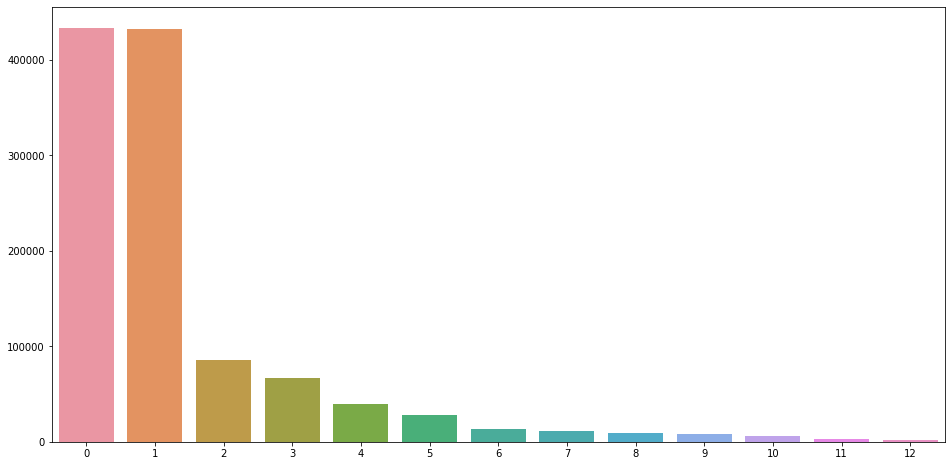

In [544]:
merged_df = pd.concat([orig_df, back_df])
merged_df["발화문"].replace("", np.nan, inplace=True)
merged_df.dropna(inplace=True)
# merged_df.to_csv("data/train+back.v8.csv", index=False)
plot_label_distribution(merged_df, orig_df["인텐트"].value_counts().index)

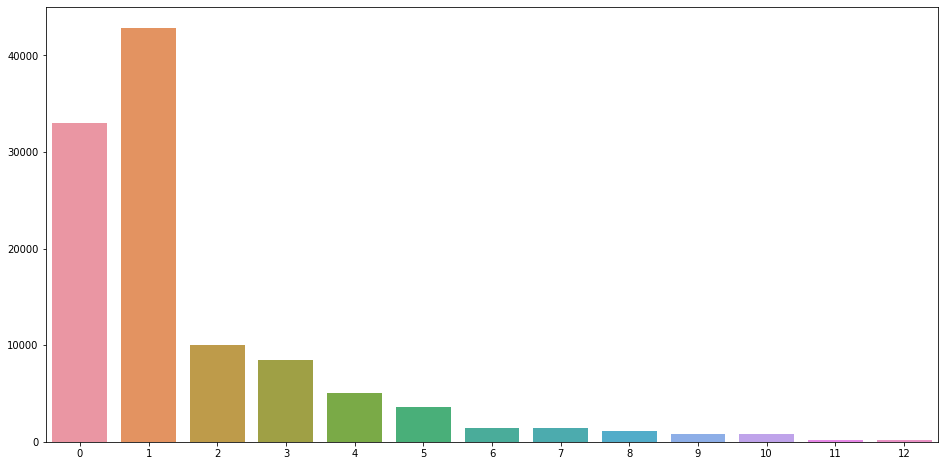

In [308]:
sampling_idx = np.random.choice(len(orig_df), size=len(back_df), replace=False)
sampled_orig_df = orig_df.iloc[sampling_idx]
merged_df2 = pd.concat([sampled_orig_df, back_df])
merged_df2["발화문"].replace("", np.nan, inplace=True)
merged_df2.dropna(inplace=True)
plot_label_distribution(merged_df2, orig_df["인텐트"].value_counts().index)

---

In [56]:
back_n_samples = get_n_samples(back_df['인텐트'])

In [82]:
merged_n_samples = get_n_samples(merged_df["인텐트"])

In [437]:
data = joblib.load("./cache/a6a72a585608f8b4d0adb49067d56cf6/data.joblib")
xs, ys = data["xs"], data["ys"]
len(xs)

514313

In [545]:
data = joblib.load("./cache/a6a72a585608f8b4d0adb49067d56cf6/data.joblib")
xs, ys = data["xs"], data["ys"]
len(xs)

512076

In [554]:
texts, labels = orig_df['발화문'].tolist(), orig_df['인텐트'].tolist()
len(texts)

715049

In [555]:
texts, labels = zip(*set(zip(texts, labels)))
len(texts)

652994

In [560]:
orig_df['인텐트'].value_counts()

제품          432162
배송          202706
교환|반품|환불     24455
행사           19914
결제           11528
AS            8559
구매            4112
웹사이트          3106
포장            2638
부가서비스         2622
매장            2071
주문             770
멤버십            406
Name: 인텐트, dtype: int64

In [564]:
len(val_df), len(val_df.drop_duplicates())

(228576, 228576)

In [561]:
orig_df.drop_duplicates()['인텐트'].value_counts()

제품          417927
배송          156965
교환|반품|환불     23707
행사           19238
결제           11332
AS            8261
구매            4088
웹사이트          3089
포장            2586
부가서비스         2578
매장            2059
주문             760
멤버십            404
Name: 인텐트, dtype: int64

In [546]:
labels, counts = np.unique(ys, return_counts=True)
labels, counts

(array(['배송', '제품', '행사'], dtype='<U2'), array([ 79917, 432158,      1]))

## Sampling

In [ ]:
batch_y = np.array([9, 6, 2, 12, 8, 5, 4, 7])
probs = torch.from_numpy((1 - n_samples[batch_y] / n_samples.max()) + 1e-4).clamp(max=1)
probs

tensor([1.0000e-04, 5.3105e-01, 9.4351e-01, 9.5402e-01, 9.9291e-01, 9.9916e-01,
        9.9531e-01, 9.9403e-01], dtype=torch.float64)

## Propensity Score

In [574]:
a = 0.55
b = 1.5
c = (np.log(n_samples.sum()) - 1) * ((b + 1) ** a)
inv_w = 1.0 + c * (n_samples + b) ** (-a)

In [709]:
inv_w

array([1.14197464, 1.12052844, 1.07970185, 1.21245598, 1.30975141,
       1.75773108, 1.02490617, 1.27208256, 1.24789009, 1.016424  ,
       1.53339695, 1.2711742 , 1.08923395])

# NLPAug

In [ ]:
train_dataset = LotteQADataset()

In [371]:
aug = naw.ContextualWordEmbsAug(model_path='klue/bert-base', aug_p=0.1)

In [381]:
%%time
ridx = np.random.randint(len(train_dataset))
original = train_dataset[ridx][0]
augmented = aug.augment(original)

print(f"Original ({ridx}):")
print(original)
print()
print("Augmented:")
print(augmented)

Original (9333):
방에다가 설치까지 해주시고 가시는 건가요?

Augmented:
['방에다가 일부러 너무 가시는 건가요?']
CPU times: user 24.7 s, sys: 221 ms, total: 24.9 s
Wall time: 812 ms


---

In [430]:
tmp_df = pd.read_csv("data/train+back.v7.csv")
len(tmp_df)

1828705

In [431]:
len(orig_df) + len(back_df)

769534